In [78]:
import torch

import unicodedata
import string
import os
import time
import random 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset
from io import open

import torch.nn as nn
import torch.nn.functional as F



CharRNN

In [8]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f'Device used {torch.get_default_device()} with name {torch.cuda.get_device_name(device)}')



Device used cuda:0 with name NVIDIA GeForce RTX 3050 Laptop GPU


### Data Preprocessing

converting unicode to ascii to simplify the RNN input layers. 
ASCII: encodes 128 english characters in the form of numbers
UNICODE: encodes 150+ modern and historic scripts along with emojis
unicode encodes more characters than ascii, so ascii can be viewed as a subset of unicode.

In [19]:
allowed_chars=string.ascii_letters + " .,;'"

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_chars
    )
    
print (f"converting 'Kožušček' to {unicodeToAscii('Kožušček')}")

converting 'Kožušček' to Kozuscek


In [24]:
# finding index of the letter in the allowed_chars
def letterToIndex(letter): 
    return allowed_chars.find(letter)

def wordToTensor(word):
    tensor=torch.zeros(len(word),1,len(allowed_chars))
    for idx,letter in enumerate(word):
        tensor[idx][0][letterToIndex(letter)]=1
    return tensor


print (f"'Ahn':{wordToTensor('Ahn')}")

# sequence length,batch size, number of characters
print((wordToTensor('Ahn')).shape) 
#here batch size shows the number of words being processed at a time

'Ahn':tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
torch.Size([3, 1, 57])


In [34]:
class NamesDataset(Dataset):
    
    def __init__(self,data_path):
        self.data_path=data_path
        labels_set=set()
        
        self.data=[]
        self.data_tensors=[]
        self.labels=[]
        self.labels_tensors=[]
        
        for filename in os.listdir(data_path):
           if filename.endswith('.txt'):
               label=os.path.splitext(filename)[0]
               labels_set.add(label)
              
               with open(os.path.join(data_path,filename),encoding='utf-8') as file:
                   lines=file.read().strip().split('\n')
                   
                   for name in lines:
                       self.data.append(name)
                       self.data_tensors.append(wordToTensor(name))
                       self.labels.append(label)
            
        self.labels_uniq = list(labels_set)
        self.labels_tensors = [torch.tensor([self.labels_uniq.index(label)], dtype=torch.long) for label in self.labels]
        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item
        
        
          
               
            
            

In [37]:
namesData=NamesDataset('C:/Users/Sania Serrao/Desktop/NLP/data/names')
print(f"loaded {len(namesData)} items of data")
label_tensor, data_tensor, data_label, data_item=namesData[0]
print(f"Label tensor:{label_tensor}\n Data tensor:{data_tensor}\n Data label:{data_label}\n Data item:{data_item}") 

loaded 20074 items of data
Label tensor:tensor([14], device='cuda:0')
 Data tensor:tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 

In [39]:
train_set, test_set = torch.utils.data.random_split(namesData, [.80, .20], generator=torch.Generator(device=device).manual_seed(2024))
print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 16060, validation examples = 4014


Network Creation


In [40]:
class CharRNN(nn.Module):
    def __init__(self,input_size,hiddensize,output_size):
        super(CharRNN,self).__init__()
        
        self.rnn=nn.RNN(input_size,hiddensize) #i2h
        self.h2o=nn.Linear(hiddensize,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

network architecture has been defined as
1) nn.RNN layer that takes the input as one-hot encoded name tensors and output to hidden layer with 128 nodes
2) nn.Linear a FC that maps hidden staate to output space with 18 nodes
3) nn.LogSoftMax converts the output into log probabilites for each class

In [42]:
n_input=len(allowed_chars)
n_hidden = 128
n_output=len(namesData.labels_uniq)
rnn = CharRNN(n_input, n_hidden, n_output)
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [68]:
#defining a hrlper function to derive the text label for most probable class  from output tensor
def label_from_output(output, labels):
    _, top_index = torch.max(output, dim=1)
    label_index = top_index.item()
    predicted_label = labels[label_index]
    return predicted_label, label_index

input = wordToTensor('Albert')
output = rnn(input)
print(output[0])
print(label_from_output(output, namesData.labels_uniq))


tensor([-2.8854, -2.7447, -2.8053, -3.0223, -2.8122, -2.8219, -2.8752, -2.9487,
        -2.9157, -2.8814, -2.9045, -2.8606, -2.9095, -2.8725, -2.9013, -3.0011,
        -3.0882, -2.8338], device='cuda:0', grad_fn=<SelectBackward0>)
('Portuguese', 1)


 Model traning and Evaluation

In [75]:
def train(
    rnn, train_data, n_epoch=10, n_batch_size=64, report_every=50, lr=0.2, criterion=nn.NLLLoss()
):
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)

    print(f"Training on dataset with n = {len(train_data)}")

    for epoch in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(train_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

      
        epoch_loss = 0
        with tqdm(batches, desc=f"Epoch {epoch}/{n_epoch}", unit="batch") as batch_bar:
            for batch in batch_bar:
                batch_loss = 0

               
                for i in batch:
                    label_tensor, text_tensor, label, text = train_data[i]
                    output = rnn(text_tensor)
                    loss = criterion(output, label_tensor)
                    batch_loss += loss

                
                batch_loss.backward()
                nn.utils.clip_grad_norm_(rnn.parameters(), 3)
                optimizer.step()
                optimizer.zero_grad()

                
                epoch_loss += batch_loss.item() / len(batch)
                batch_bar.set_postfix(batch_loss=batch_loss.item() / len(batch))

       
        avg_epoch_loss = epoch_loss / len(batches)
        all_losses.append(avg_epoch_loss)
        current_loss = 0

        if epoch % report_every == 0:
            print(f"Epoch {epoch} ({epoch / n_epoch:.0%}): Average loss = {avg_epoch_loss:.4f}")

    return all_losses


In [76]:
all_losses = train(rnn, train_set, n_epoch=27, lr=0.15, report_every=5)


Training on dataset with n = 16060


Epoch 1/27:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 5/27: 100%|██████████| 250/250 [00:32<00:00,  7.69batch/s, batch_loss=0.667]


Epoch 5 (19%): Average loss = 0.7058


Epoch 10/27: 100%|██████████| 250/250 [00:27<00:00,  9.01batch/s, batch_loss=0.505]


Epoch 10 (37%): Average loss = 0.5891


Epoch 15/27: 100%|██████████| 250/250 [00:47<00:00,  5.29batch/s, batch_loss=0.617]


Epoch 15 (56%): Average loss = 0.5012


Epoch 20/27: 100%|██████████| 250/250 [00:27<00:00,  9.10batch/s, batch_loss=0.251]


Epoch 20 (74%): Average loss = 0.4366


Epoch 25/27: 100%|██████████| 250/250 [00:29<00:00,  8.60batch/s, batch_loss=0.539]


Epoch 25 (93%): Average loss = 0.3902


Epoch 27/27: 100%|██████████| 250/250 [00:30<00:00,  8.21batch/s, batch_loss=0.513]


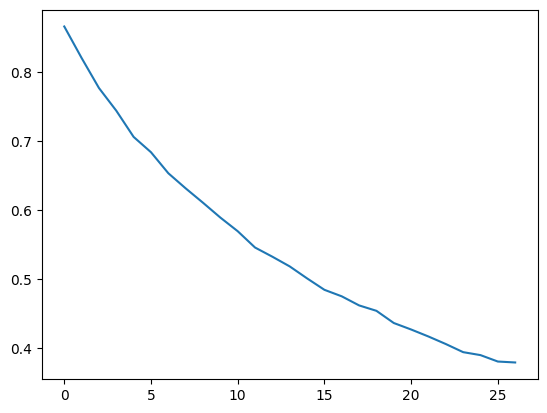

In [79]:
plt.figure()
plt.plot(all_losses)
plt.show()

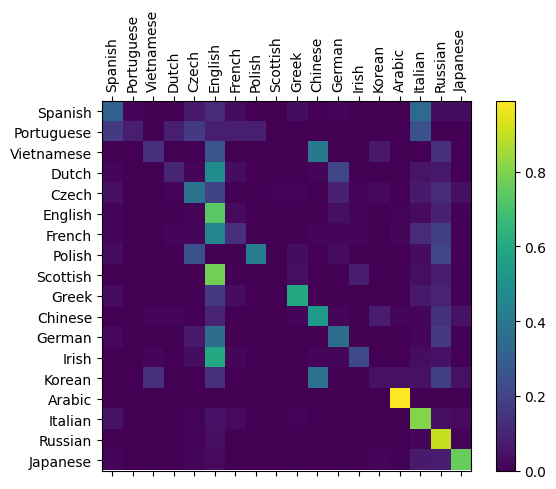

In [80]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() 
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1


    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    plt.show()



evaluate(rnn, test_set, classes=namesData.labels_uniq)